# Test Script for Customer Value Model (CVM) Scoring
## Joe Nguyen | 21Nov2019

In [148]:
import sys
import os
import pandas as pd
import numpy as np
import subprocess
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns

In [62]:
# Local modules
# sys.path.append('/home/jovyan/a01_repos')
import auto_ml
import fit_gbm
import helper

sys.path.append('/home/jovyan/a01_repos/wx_tools')
import hhan_util as utl

### Copy Files

In [21]:
# Copy project table_whitelist_cmd
filename = 'table_whitelist_cmd.txt'
gcp_path = f'gs://wx-projects/2019/ecom-acquisition/configs/{filename}'
local_path = f'/home/jovyan/a00_projects/a01_cvm/a01_data/cvm2783/'
gcp_path_test = f'gs://wx-personal/joe/test/configs/'
subprocess.call(f'gsutil -m cp {gcp_path} {local_path}', shell=True)
subprocess.call(f'gsutil -m cp {gcp_path} {gcp_path_test}', shell=True)

0

In [33]:
# !gsutil -m cp -r gs://wx-projects/2019/ecom-acquisition/fit_gbm /home/jovyan/a01_repos

In [211]:
# !rm -r ./auto_ml
# !rm -r ./helper

In [215]:
# # Han's older auto_ml
# !gsutil -m cp -r gs://wx-projects/2019/ecom-acquisition/auto_ml ./
# !gsutil -m cp -r gs://wx-projects/2019/ecom-acquisition/helper ./

In [ ]:
# Copy files to local
# Campaign file
subprocess.call([f'gsutil -m cp {s3_filepath_cmpgn} {local_cvm_path}'], shell=True)

In [ ]:
# Models
subprocess.call([f'gsutil -m cp {gcp_mdl_path_pick} {local_mdl_path_pick}'], shell=True)
subprocess.call([f'gsutil -m cp {gcp_mdl_path_deli} {local_mdl_path_deli}'], shell=True)

In [ ]:
# Copy models to local
#!gsutil -m cp gs://wx-projects/2019/ecom-acquisition/pick-all-model-no-onln-2019-07-18/model_selector/model_object.pickle /home/jovyan/a00_projects/a01_cvm/a03_models/model_object_pick.pickle
#!gsutil -m cp gs://wx-projects/2019/ecom-acquisition/deli-all-model-no-onln-2019-07-22/model_selector/model_object.pickle /home/jovyan/a00_projects/a01_cvm/a03_models/model_object_deli.pickle

In [ ]:
# ADHOC: copy output scoring file (for test data reconciliation)
s3_filepath = 's3://data-preprod-redshift-exports/Hans/CVM-2783_scored.csv'
subprocess.call([f'gsutil -m cp {s3_filepath} {local_cvm_path}'], shell=True)

In [ ]:
# ADHOC: copy cmd files


## Project Directories

In [63]:
# Campaign code and date
cvm = '2783'
ref_dt = '2019-09-29'
filename_cmpgn = 'CA2DS_CVM2783_ACQ.csv'
filename_whitelist = f'cvm{cvm}_whitelist_columns.txt'
filename_custBase = 'cust_base.parquet'
filename_whitelist_tbl = 'table_whitelist_cmd.txt'
filename_wcmd = 'w_cmd.parquet'


# -------------------------------------------------
# GCP
# -------------------------------------------------
gcp_prj_path = 'gs://wx-personal/joe/test'
# gcp_proj_path = 'gs://wx-projects/2019/ecom-acquisition'
gcp_data_path = os.path.join(gcp_prj_path, 'data')
gcp_configs_path = os.path.join(gcp_prj_path, 'configs')
gcp_cvm_path = os.path.join(gcp_data_path, f'cvm{cvm}')
gcp_cmd_path = os.path.join(gcp_cvm_path, 'cmd')

# Models
gcp_mdl_path_pick = 'gs://wx-projects/2019/ecom-acquisition/pick-all-model-no-onln-2019-07-18/model_selector/model_object.pickle'
gcp_mdl_path_deli = 'gs://wx-projects/2019/ecom-acquisition/deli-all-model-no-onln-2019-07-22/model_selector/model_object.pickle'

# Campaign file
s3_filepath_cmpgn = 's3://data-preprod-redshift-exports/Hans/CA2DS_CVM2783_ACQ.csv'


# -------------------------------------------------
# Local
# -------------------------------------------------
# Models
local_mdl_path = '/home/jovyan/a00_projects/a01_cvm/a03_models'
local_mdl_path_pick = f'{local_mdl_path}/model_object_pick.pickle'
local_mdl_path_deli = f'{local_mdl_path}/model_object_deli.pickle'

# Campaign file
local_cvm_path = f'/home/jovyan/a00_projects/a01_cvm/a01_data/cvm{cvm}'
local_cmd_path = f'/home/jovyan/a00_projects/a01_cvm/a01_data/cvm{cvm}/cmd'
# local_cmpgn_file_path = os.path.join(local_cvm_path, )
# local_cmd_file_path = os.path.join(local_cmd_path, 'w_cmd.parquet')

local_auto_ml = '/home/jovyan/a01_repos/auto_ml'

In [64]:
# Create local folder
if not os.path.exists(local_cvm_path):
    os.makedirs(local_cvm_path)
if not os.path.exists(local_cmd_path):
    os.makedirs(local_cmd_path)

## Functions

In [65]:
def Extract_Mdl_Cols(Mdl_):
    # Nominal variables: remove category suffix (pefix_sep=='||')
    colLs = set([c.split('||')[0] if '||' in c else c for c in Mdl_.columns])
    colFixLs = {c.replace('f_unknown_','') if 'unknown' in c else c for c in colLs}
    return colFixLs

In [66]:
def Mdl_To_Whitelist(mdlLs, filename, localPath, gcpPath):
    '''
    mdlLs - list of models
    '''
    colLs = []
    for i,mdl in enumerate(mdlLs):
        colLs0 = Extract_Mdl_Cols(mdl)
        colLs += colLs0
        print(f'Model {i} #columns: {len(colLs0)}')
    colLs = set(colLs)
    print(f'Total unique #columns: {len(colLs)}')
    
    # Store whitelist
    localPath = os.path.join(localPath, filename)
    with open(localPath, 'w') as f:
        for text in colLs:
            f.write(text + '\n')
    
    # Copy to gcp
    gcpPath = os.path.join(gcpPath, filename)
    subprocess.call([f'gsutil -m cp {localPath} {gcpPath}'], shell=True)
    return colLs

In [103]:
def Calc_Cust_Score(mdl_type, mdl_path, cmd_path):
    
    # Copy model pickle
    if os.path.exists('model_object.pickle'):
        subprocess.call(['rm', 'model_object.pickle'])
    subprocess.call(['cp', mdl_path, './'])

    # Rename file
    subprocess.call([
        'mv'
        ,f'./{os.path.basename(mdl_path)}'
        ,'./model_object.pickle']
    )
    # !find . -type f -name "*.pickle"
    
    print('===============Scoring==================')
    scoringStr = f'PYTHONPATH=../:. python ./auto_ml/scoring_udf/udf_script/dist_udf.py {cmd_path}'
    print(scoringStr)
    subprocess.check_output(scoringStr, shell=True)
    
    print('============Renaming folder=============')
    subprocess.call(['mv', 'output', f'output_{mdl_type}_cvm{cvm}'])
    
    # Return output filepath
    return f'./output_{mdl_type}_cvm{cvm}/processed.parquet'

In [68]:
def Calc_Cust_Rank(filepath, mdl_type):
    
    # Customer score
    custScore = pq.read_table(filepath).to_pandas()
    custScore = custScore[['crn', 'score']].set_index('crn')
    #     rename({'score':f'score_{mdl_type}'}, axis=1)
    
    # Rank and decile
    custScore['rank'] = custScore['score'].rank(ascending=False).astype(int)
    custScore['decile'] = pd.qcut(custScore['score'], q=10, labels=range(10, 0, -1))
    
    # Append {mdl_type} suffix
    custScore.columns = [f'{mdl_type}_{col}' for col in custScore.columns.tolist()]
    return custScore

## Process Files

### Load Models

In [69]:
Mdl_pick = utl.unpickle_item(local_mdl_path_pick)
Mdl_deli = utl.unpickle_item(local_mdl_path_deli)
mdlLs = [Mdl_pick, Mdl_deli]

In [70]:
# Extract column names
colLs = Mdl_To_Whitelist(mdlLs, filename_whitelist, local_cvm_path, gcp_configs_path)

Model 0 #columns: 226
Model 1 #columns: 250
Total unique #columns: 362


### Process Campaign File

In [122]:
filepath = f'{local_cvm_path}/{filename_cmpgn}'
cmpgnData = pd.read_csv(filepath)
print(cmpgnData.shape)
# cmpgnData.head(2)

(3557807, 14)


In [123]:
cmpgnData.head(2)

selection                  crn            prmry_crn  lylty_card_nbr  \
0  MARKETABLE  1000000000000005864  1000000000000005864   9344754173179   
1  MARKETABLE  1000000000000006051  1000000000000006051   9344401333772   

  lylty_card_rgstr_flag lylty_card_status_desc lylty_card_actv_date is_staff  \
0                     Y    Active With Details           2014-10-21        N   
1                     Y    Active With Details           2007-09-10        N   

  onboarding_cust cvm_macro_segment_curr  cvm_weeks_since_last_shop  \
0               N                   LVLF                          1   
1               N                 HVHIGH                          0   

   cvm_weeks_since_last_scan cvm_universal_control cvm_qff_status  
0                          3                     N            NaN  
1                          1                     N           Link

In [79]:
# Extract crn, ref_dt; create parquet and push to gcp
filepath = f'{local_cvm_path}/{filename_custBase}'
cmpgnData['ref_dt'] = ref_dt
cmpgnData[['crn', 'ref_dt']].to_parquet(filepath, engine='pyarrow')

# Load to gcp
subprocess.call([f'gsutil -m cp {filepath} {gcp_cvm_path}'], shell=True)

0

In [84]:
# Table joiner (to CMD)
param_d = {'in_type': 'parquet',
           'in_path': f'{gcp_cvm_path}/{filename_custBase}',
           'out_path': gcp_cmd_path,
           'part_format': 'yyyy-MM-dd', 
           'join_type': 'left', 
           'incl_tables': f'{gcp_configs_path}/{filename_whitelist_tbl}',
           'incl_cols': f'{gcp_configs_path}/{filename_whitelist}', 
           'db': 'cmd',
           'incl_fuel': 'false', 
           'out_file_num': '1'}
param_str = 'INPUT_TYPE={in_type},INPUT_PATH={in_path},OUTPUT_PATH={out_path},' + \
    'PARTITION_FORMAT={part_format},JOIN_TYPE={join_type},FILE_INCLUDED_TABLES={incl_tables},' + \
    'FILE_INCLUDED_COLUMNS={incl_cols},DATABASE={db},INCLUDE_FUEL={incl_fuel},OUT_FILE_NUM={out_file_num}'
param_str = param_str.format(**param_d)
print(param_str)

INPUT_TYPE=parquet,INPUT_PATH=gs://wx-personal/joe/test/data/cvm2783/cust_base.parquet,OUTPUT_PATH=gs://wx-personal/joe/test/data/cvm2783/cmd,PARTITION_FORMAT=yyyy-MM-dd,JOIN_TYPE=left,FILE_INCLUDED_TABLES=gs://wx-personal/joe/test/configs/table_whitelist_cmd.txt,FILE_INCLUDED_COLUMNS=gs://wx-personal/joe/test/configs/cvm2783_whitelist_columns.txt,DATABASE=cmd,INCLUDE_FUEL=false,OUT_FILE_NUM=1


In [13]:
# One off command
# !gcloud init

In [14]:
# !gcloud dataproc workflow-templates instantiate prd-spark-cmd-joiner-16 --async --region us-east4 --parameters {param_str}

In [85]:
# Table joiner (to CMD)
subprocess.check_output(['gcloud', 'dataproc', 'workflow-templates', 'instantiate', 
                         'prd-spark-cmd-joiner', '--async', '--region', 'us-east4', 
                         '--parameters', param_str], stderr=subprocess.STDOUT)

# subprocess.check_output(['gcloud', 'dataproc', 'workflow-templates', 'instantiate', 
#                          'prd-spark-cmd-joiner-16', '--async', '--region', 'us-east4', 
#                          '--parameters', param_str], stderr=subprocess.STDOUT)

b"WARNING: Dataproc --region flag will become required in January 2020. Please either specify this flag, or set default by running 'gcloud config set dataproc/region <your-default-region>'\nInstantiating [prd-spark-cmd-joiner-16] with operation [projects/wx-bq-poc/regions/us-east4/operations/45a89e27-c397-3c79-857a-9bf0f6b7d018].\n"

In [86]:
# Transfer table-joiner output to local
utl.get_file_from_gcp(param_d['out_path'], local_cvm_path, transfer_only=True)
# utl.get_file_from_gcp(
#     'gs://wx-projects/2019/ecom-acquisition/data/cvm2783/cmd'
#     ,local_cvm_path
#     ,transfer_only=True
# )

From: gs://wx-personal/joe/test/data/cvm2783/cmd
To: /home/jovyan/a00_projects/a01_cvm/a01_data/cvm2783
Read: /home/jovyan/a00_projects/a01_cvm/a01_data/cvm2783cmd/
gsutil -m cp -r gs://wx-personal/joe/test/data/cvm2783/cmd /home/jovyan/a00_projects/a01_cvm/a01_data/cvm2783
Transferring ...


In [87]:
# Merge cmd files (as list) and rename "w_cmd.parquet"
cmdFileLs = [f for f in os.listdir(local_cmd_path) if f.startswith('part')][0]
subprocess.call(['mv', f'{local_cmd_path}/{cmdFileLs}', f'{local_cmd_path}/{filename_wcmd}'])

0

In [194]:
w_cmd = pq.read_table(f'{local_cmd_path}/{filename_wcmd}').to_pandas()
w_cmd.shape

(3557807, 364)

In [195]:
w_cmd['ref_dt'].unique()

array([datetime.date(2019, 9, 29)], dtype=object)

In [196]:
w_cmd_hh = pq.read_table(f'{local_cmd_path}/w_cmd_hans.parquet').to_pandas()
print(w_cmd.shape)
w_cmd['ref_dt'].unique()

(3557807, 364)


array([datetime.date(2019, 9, 29)], dtype=object)

## Scoring

### Pick Up

In [184]:
cmd_path

'/home/jovyan/a00_projects/a01_cvm/a01_data/cvm2783/cmd/w_cmd_hans.parquet'

In [185]:
# cmd_path = f'{local_cmd_path}/{filename_wcmd}'
cmd_path = f'{local_cmd_path}/w_cmd_hans.parquet'

# Pick and deli model scores
mdl_type = 'pick'
mdl_path = local_mdl_path_pick

In [186]:
# Score model (long computation ~3 mins)
outFilepath = Calc_Cust_Score(mdl_type, mdl_path, cmd_path)

===============Scoring==================
PYTHONPATH=../:. python ./auto_ml/scoring_udf/udf_script/dist_udf.py /home/jovyan/a00_projects/a01_cvm/a01_data/cvm2783/cmd/w_cmd_hans.parquet
============Renaming folder=============


In [172]:
# outFilepath = f'./output_{mdl_type}_cvm{cvm}/processed.parquet'
custScorePick = Calc_Cust_Rank(outFilepath, mdl_type)
custScorePick.head(2)

pick_score  pick_rank pick_decile
crn                                                   
1000000000000000753    0.000150    3492915          10
1000000000000000968    0.000758    1765890           5

In [187]:
custScorePick = Calc_Cust_Rank(outFilepath, mdl_type)
custScorePick.head(2)

pick_score  pick_rank pick_decile
crn                                                   
1000000000000000919    0.001400    1281048           4
1000000000000001020    0.009801     229635           1

### Delivery

In [188]:
# Pick and deli model scores
mdl_type = 'deli'
mdl_path = local_mdl_path_deli

In [189]:
# Score model (long computation ~3 mins)
outFilepath = Calc_Cust_Score(mdl_type, mdl_path, cmd_path)

===============Scoring==================
PYTHONPATH=../:. python ./auto_ml/scoring_udf/udf_script/dist_udf.py /home/jovyan/a00_projects/a01_cvm/a01_data/cvm2783/cmd/w_cmd_hans.parquet
============Renaming folder=============


In [179]:
# outFilepath = f'./output_{mdl_type}_cvm{cvm}/processed.parquet'
custScoreDeli = Calc_Cust_Rank(outFilepath, mdl_type)
custScoreDeli.head(2)

deli_score  deli_rank deli_decile
crn                                                   
1000000000000000753    0.004016    1046234           3
1000000000000000968    0.001204    2807066           8

In [190]:
# outFilepath = f'./output_{mdl_type}_cvm{cvm}/processed.parquet'
custScoreDeli = Calc_Cust_Rank(outFilepath, mdl_type)
custScoreDeli.head(2)

deli_score  deli_rank deli_decile
crn                                                   
1000000000000000919    0.003412    1186323           4
1000000000000001020    0.018337      73001           1

In [200]:
# Merge pickup and delivery customer scores
custScore = custScorePick.merge(custScoreDeli, left_index=True, right_index=True)

# Selected model for customer
custScore['model'] = np.where(
    custScore['pick_score'] >= custScore['deli_score']
    ,'pick', 'delivery'
)

In [201]:
custScore['model'].value_counts()

delivery    2674590
pick         883217
Name: model, dtype: int64

In [120]:
custScore['model'].value_counts()

delivery    2699838
pick         857969
Name: model, dtype: int64

In [202]:
# Selection group
custScore['selection_group'] = np.where(
    (custScore['pick_decile'] == 1) | (custScore['deli_decile'] == 1)
    ,'Model'
    ,'Do Not Send'
)

In [101]:
# Save as csv
colNames = ['deli_rank', 'pick_rank', 'model', 'selection_group', 'pick_decile', 'deli_decile']
custScoreOut = custScore[colNames]
custScoreOut.reset_index(inplace=True)
colNames = ['crn', 'deli_score_rank', 'pick_score_rank', 'model', 'selection_group', 'pick_score_decile', 'deli_score_decile']
custScoreOut.columns = colNames
custScoreOut.to_csv(f'./CVM-{cvm}_scored_jn.csv', index=False)

In [87]:
custScore.head()

crn  deli_score_rank  pick_score_rank     model  \
0  1000000000000000440          1986887          3232364  delivery   
1  1000000000000001368          1138857          2391853  delivery   
2  1000000000000001502          2723410           827773      pick   
3  1000000000000001653          1283629           919999  delivery   
4  1000000000000002537          2952746          2566696  delivery   

  selection_group pick_score_decile deli_score_decile  
0     Do Not Send                10                 6  
1     Do Not Send                 7                 4  
2     Do Not Send                 3                 8  
3     Do Not Send                 3                 4  
4     Do Not Send                 8                 9

In [56]:
# custScore[(custScore['pick_decile'] == 1) & (custScore['deli_decile'] != 1)]

In [199]:
custScore

pick_score  pick_rank pick_decile  deli_score  deli_rank  \
crn                                                                             
1000000000000000919    0.001400    1281048           4    0.003412    1186323   
1000000000000001020    0.009801     229635           1    0.018337      73001   
1000000000000001262    0.000274    2964449           9    0.006254     514737   
1000000000000002319    0.000237    3136403           9    0.002183    1854950   
1000000000000003999    0.000340    2687734           8    0.001920    2059493   
...                         ...        ...         ...         ...        ...   
1100000000166270559    0.001057    1479114           5    0.003787    1046435   
1100000000166284374    0.004637     524536           2    0.008642     302190   
1100000000166288936    0.003537     671993           2    0.004454     847399   
1100000000168049654    0.000749    1758254           5    0.000621    3355096   
1100000000168058087    0.000919    1584385           5    0.001045    2928499   

                    deli_decile     model  
crn                                        
1000000000000000919           4  delivery  
1000000000000001020           1  delivery  
1000000000000001262           2  delivery  
1000000000000002319           6  delivery  
1000000000000003999           6  delivery  
...                         ...       ...  
1100000000166270559           3  delivery  
1100000000166284374           1  delivery  
1100000000166288936           3  delivery  
1100000000168049654          10      pick  
1100000000168058087           9  delivery  

[3557807 rows x 7 columns]

In [88]:
custScore.groupby(['selection_group','model'])['model'].count()

selection_group  model   
Do Not Send      delivery    2446700
                 pick         605678
Model            delivery     253138
                 pick         252291
Name: model, dtype: int64

In [205]:
# Customer count by model type (pick-up or delivery)
print(custScore['model'].value_counts())
print(custScore['model'].value_counts(normalize=True).round(4))
print(custScore.shape)

delivery    2674590
pick         883217
Name: model, dtype: int64
delivery    0.7518
pick        0.2482
Name: model, dtype: float64
(3557807, 8)


In [206]:
print(custScore['selection_group'].value_counts())
print(custScore['selection_group'].value_counts(normalize=True).round(4))

Do Not Send    3050107
Model           507700
Name: selection_group, dtype: int64
Do Not Send    0.8573
Model          0.1427
Name: selection_group, dtype: float64


In [203]:
# Customer count by selection group, model type
custCnt = custScore.groupby(['selection_group', 'model'])['model'].count().rename('cnt')
print(custCnt)
custCnt / custCnt.groupby(level=0).sum()

selection_group  model   
Do Not Send      delivery    2425830
                 pick         624277
Model            delivery     248760
                 pick         258940
Name: cnt, dtype: int64


selection_group  model   
Do Not Send      delivery    0.795326
                 pick        0.204674
Model            delivery    0.489974
                 pick        0.510026
Name: cnt, dtype: float64

# QA

In [126]:
f'gsutil -m cp -r {path_deli} ./'

'gsutil -m cp -r gs://wx-projects/2019/ecom-acquisition/output_deli_cvm2783 ./'

In [127]:
# Copy Han's output scoring data files
path_deli = 'gs://wx-projects/2019/ecom-acquisition/output_deli_cvm2783'
path_pick = 'gs://wx-projects/2019/ecom-acquisition/output_pick_cvm2783'

subprocess.call(f'gsutil -m cp -r {path_deli} ./', shell=True)
subprocess.call(f'gsutil -m cp -r {path_pick} ./', shell=True)

0

In [128]:
custScoreDeli_hh = Calc_Cust_Rank('./output_deli_cvm2783/processed.parquet', 'deli')
custScoreDeli_hh.head(2)

deli_score  deli_rank deli_decile
crn                                                   
1000000000000000919    0.003412    1186323           4
1000000000000001020    0.018337      73001           1

In [129]:
custScorePick_hh = Calc_Cust_Rank('./output_pick_cvm2783/processed.parquet', 'pick')
custScorePick_hh.head(2)

pick_score  pick_rank pick_decile
crn                                                   
1000000000000000919    0.001400    1281048           4
1000000000000001020    0.009801     229635           1

In [130]:
# Merge pickup and delivery customer scores
custScore_hh = custScorePick_hh.merge(custScoreDeli_hh, left_index=True, right_index=True)

# Selected model for customer
custScore_hh['model'] = np.where(
    custScore_hh['pick_score'] >= custScore_hh['deli_score']
    ,'pick', 'delivery'
)

In [131]:
custScore_hh['model'].value_counts()

delivery    2674590
pick         883217
Name: model, dtype: int64

In [134]:
# QA compare customer scores between jn hh
df = custScore.merge(custScore_hh, left_index=True, right_index=True, suffixes=('_jn', '_hh'))
print(df.shape)
df.head(2)

(3557807, 14)


pick_score_jn  pick_rank_jn pick_decile_jn  \
crn                                                               
1000000000000000753       0.000150       3492915             10   
1000000000000000968       0.000758       1765890              5   

                     deli_score_jn  deli_rank_jn deli_decile_jn  model_jn  \
crn                                                                         
1000000000000000753       0.004016       1046234              3  delivery   
1000000000000000968       0.001204       2807066              8  delivery   

                     pick_score_hh  pick_rank_hh pick_decile_hh  \
crn                                                               
1000000000000000753       0.000150       3493255             10   
1000000000000000968       0.000737       1774093              5   

                     deli_score_hh  deli_rank_hh deli_decile_hh  model_hh  
crn                                                                        
1000000000000000753       0.004697        788081              3  delivery  
1000000000000000968       0.001165       2797971              8  delivery

In [143]:
# Differences
df['pick_diff'] = np.abs(df['pick_score_jn'] - df['pick_score_hh'])
df['deli_diff'] = np.abs(df['deli_score_jn'] - df['deli_score_hh'])
df['pick_diff_perc'] = df['pick_diff'] / df['pick_score_hh'] * 100.0
df['deli_diff_perc'] = df['deli_diff'] / df['deli_score_hh'] * 100.0
df.head(3)

pick_score_jn  pick_rank_jn pick_decile_jn  \
crn                                                               
1000000000000000753       0.000150       3492915             10   
1000000000000000968       0.000758       1765890              5   
1000000000000001193       0.000344       2686708              8   

                     deli_score_jn  deli_rank_jn deli_decile_jn  model_jn  \
crn                                                                         
1000000000000000753       0.004016       1046234              3  delivery   
1000000000000000968       0.001204       2807066              8  delivery   
1000000000000001193       0.001095       2920175              9  delivery   

                     pick_score_hh  pick_rank_hh pick_decile_hh  \
crn                                                               
1000000000000000753       0.000150       3493255             10   
1000000000000000968       0.000737       1774093              5   
1000000000000001193       0.000456       2318040              7   

                     deli_score_hh  deli_rank_hh deli_decile_hh  model_hh  \
crn                                                                         
1000000000000000753       0.004697        788081              3  delivery   
1000000000000000968       0.001165       2797971              8  delivery   
1000000000000001193       0.001090       2879338              9  delivery   

                        pick_diff  deli_diff  pick_diff_perc  deli_diff_perc  
crn                                                                           
1000000000000000753  4.939057e-07   0.000681        0.328712       14.493019  
1000000000000000968  2.080418e-05   0.000039        2.823798        3.324788  
1000000000000001193  1.119663e-04   0.000005       24.572508        0.433990

In [145]:
df[df['pick_diff_perc'] < 2]

pick_score_jn  pick_rank_jn pick_decile_jn  \
crn                                                               
1000000000000000753       0.000150       3492915             10   
1000000000000004516       0.000274       2970985              9   
1000000000000004608       0.000895       1622452              5   
1000000000000005359       0.007106        357624              2   
1000000000000007102       0.000432       2401144              7   
...                            ...           ...            ...   
1100000000165866701       0.000734       1795560              6   
1100000000165878452       0.001063       1491728              5   
1100000000165895605       0.001039       1507975              5   
1100000000166242859       0.012242        191295              1   
1100000000168055581       0.000924       1596682              5   

                     deli_score_jn  deli_rank_jn deli_decile_jn  model_jn  \
crn                                                                         
1000000000000000753       0.004016       1046234              3  delivery   
1000000000000004516       0.002630       1639421              5  delivery   
1000000000000004608       0.002496       1719353              5  delivery   
1000000000000005359       0.007554        434910              2  delivery   
1000000000000007102       0.001617       2395303              7  delivery   
...                            ...           ...            ...       ...   
1100000000165866701       0.002607       1652588              5  delivery   
1100000000165878452       0.001183       2828912              8  delivery   
1100000000165895605       0.001501       2507097              8  delivery   
1100000000166242859       0.140403          4500              1  delivery   
1100000000168055581       0.001480       2526888              8  delivery   

                     pick_score_hh  pick_rank_hh pick_decile_hh  \
crn                                                               
1000000000000000753       0.000150       3493255             10   
1000000000000004516       0.000270       2980724              9   
1000000000000004608       0.000889       1610448              5   
1000000000000005359       0.007085        336378              1   
1000000000000007102       0.000436       2372655              7   
...                            ...           ...            ...   
1100000000165866701       0.000727       1786764              6   
1100000000165878452       0.001063       1475019              5   
1100000000165895605       0.001044       1488160              5   
1100000000166242859       0.012178        174802              1   
1100000000168055581       0.000924       1579985              5   

                     deli_score_hh  deli_rank_hh deli_decile_hh  model_hh  \
crn                                                                         
1000000000000000753       0.004697        788081              3  delivery   
1000000000000004516       0.002432       1685211              5  delivery   
1000000000000004608       0.002490       1648537              5  delivery   
1000000000000005359       0.007515        383023              2  delivery   
1000000000000007102       0.001627       2320114              7  delivery   
...                            ...           ...            ...       ...   
1100000000165866701       0.001967       2020090              6  delivery   
1100000000165878452       0.001183       2778877              8  delivery   
1100000000165895605       0.001501       2444570              7  delivery   
1100000000166242859       0.135572          3934              1  delivery   
1100000000168055581       0.001480       2465297              7  delivery   

                        pick_diff  deli_diff  pick_diff_perc  deli_diff_perc  
crn                                                                           
1000000000000000753  4.939057e-07   0.000681        0.328712       14.493019  
1000000000000004516  3.828553e-06   

In [149]:
df[df['deli_diff_perc'] > 2]

pick_score_jn  pick_rank_jn pick_decile_jn  \
crn                                                               
1000000000000000753       0.000150       3492915             10   
1000000000000000968       0.000758       1765890              5   
1000000000000004516       0.000274       2970985              9   
1000000000000005864       0.000816       1698918              5   
1000000000000008130       0.000138       3519665             10   
...                            ...           ...            ...   
1100000000166289365       0.000588       2028158              6   
1100000000166290114       0.000502       2215334              7   
1100000000168031494       0.001469       1266091              4   
1100000000168059312       0.001964       1068315              4   
1100000000168070443       0.004061        617509              2   

                     deli_score_jn  deli_rank_jn deli_decile_jn  model_jn  \
crn                                                                         
1000000000000000753       0.004016       1046234              3  delivery   
1000000000000000968       0.001204       2807066              8  delivery   
1000000000000004516       0.002630       1639421              5  delivery   
1000000000000005864       0.000457       3485512             10      pick   
1000000000000008130       0.005368        718121              3  delivery   
...                            ...           ...            ...       ...   
1100000000166289365       0.004732        850871              3  delivery   
1100000000166290114       0.001245       2765046              8  delivery   
1100000000168031494       0.001925       2124273              6  delivery   
1100000000168059312       0.010014        277520              1  delivery   
1100000000168070443       0.007263        462003              2  delivery   

                     pick_score_hh  pick_rank_hh pick_decile_hh  \
crn                                                               
1000000000000000753       0.000150       3493255             10   
1000000000000000968       0.000737       1774093              5   
1000000000000004516       0.000270       2980724              9   
1000000000000005864       0.001017       1507290              5   
1000000000000008130       0.000135       3525496             10   
...                            ...           ...            ...   
1100000000166289365       0.000567       2053194              6   
1100000000166290114       0.000533       2126260              6   
1100000000168031494       0.001348       1307303              4   
1100000000168059312       0.001623       1178733              4   
1100000000168070443       0.001656       1164616              4   

                     deli_score_hh  deli_rank_hh deli_decile_hh  model_hh  \
crn                                                                         
1000000000000000753       0.004697        788081              3  delivery   
1000000000000000968       0.001165       2797971              8  delivery   
1000000000000004516       0.002432       1685211              5  delivery   
1000000000000005864       0.000518       3436284             10      pick   
1000000000000008130       0.004245        903812              3  delivery   
...                            ...           ...            ...       ...   
1100000000166289365       0.003270       1245478              4  delivery   
1100000000166290114       0.001198       2762239              8  delivery   
1100000000168031494       0.002076       1934041              6  delivery   
1100000000168059312       0.008023        343483              1  delivery   
1100000000168070443       0.005479        630239              2  delivery   

                        pick_diff  deli_diff  pick_diff_perc  deli_diff_perc  
crn                                                                           
1000000000000000753  4.939057e-07   0.000681        0.328712       14.493019  
1000000000000000968  2.080418e-05   

In [138]:
print(df.shape)
print(df[['pick_score_jn', 'pick_score_hh', 'pick_diff']].sum(axis=0))
print(df[['deli_score_jn', 'deli_score_hh', 'deli_diff']].sum(axis=0))

(3557807, 16)
pick_score_jn    11931.989729
pick_score_hh    11138.033290
pick_diff          793.956439
dtype: float64
deli_score_jn    15941.304861
deli_score_hh    14578.983338
deli_diff         1362.321524
dtype: float64


In [141]:
df['pick_diff'].sum() / df['pick_score_hh'].sum() * 100.0

7.128336019301732

In [140]:
df['deli_diff'].sum() / df['deli_score_hh'].sum() * 100.0

9.344420609396995

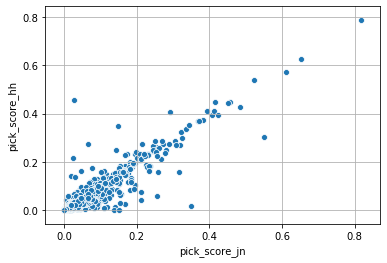

In [153]:
# Plot
sns.scatterplot(data=df.sample(100000), x='pick_score_jn', y='pick_score_hh')
plt.grid()
plt.show()

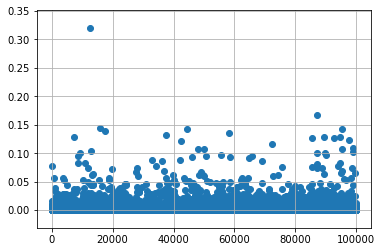

In [157]:
plt.scatter(x= np.arange(0,100000), y=df['pick_diff'].sample(100000))
# sns.scatterplot(data=df['pick_diff'].sample(100000))
plt.grid()
plt.show()

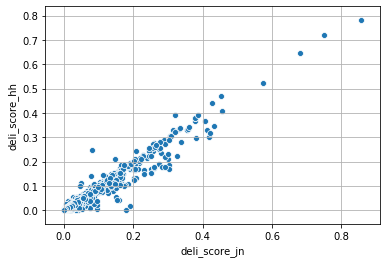

In [154]:
# Plot
sns.scatterplot(data=df.sample(100000), x='deli_score_jn', y='deli_score_hh')
plt.grid()
plt.show()

In [132]:
# CVM_2783_scored = pd.reasd_csv(f'{local_cvm_path}/CVM-2783_scored.csv', index_col='crn')

In [158]:
# Differences by decile

In [163]:
df.head(2)

pick_score_jn  pick_rank_jn pick_decile_jn  \
crn                                                               
1000000000000000753       0.000150       3492915             10   
1000000000000000968       0.000758       1765890              5   

                     deli_score_jn  deli_rank_jn deli_decile_jn  model_jn  \
crn                                                                         
1000000000000000753       0.004016       1046234              3  delivery   
1000000000000000968       0.001204       2807066              8  delivery   

                     pick_score_hh  pick_rank_hh pick_decile_hh  \
crn                                                               
1000000000000000753       0.000150       3493255             10   
1000000000000000968       0.000737       1774093              5   

                     deli_score_hh  deli_rank_hh deli_decile_hh  model_hh  \
crn                                                                         
1000000000000000753       0.004697        788081              3  delivery   
1000000000000000968       0.001165       2797971              8  delivery   

                        pick_diff  deli_diff  pick_diff_perc  deli_diff_perc  \
crn                                                                            
1000000000000000753  4.939057e-07   0.000681        0.328712       14.493019   
1000000000000000968  2.080418e-05   0.000039        2.823798        3.324788   

                     pick_decile_error  
crn                                     
1000000000000000753                  0  
1000000000000000968                  0

In [162]:
df['pick_decile_error'] = (df['pick_decile_jn'] != df['pick_decile_hh']).astype('int8')

In [169]:
df.groupby(['pick_decile_hh', 'pick_decile_error'])['pick_decile_error'].count()

pick_decile_hh  pick_decile_error
10              0                    325206
                1                     30575
9               0                    285794
                1                     69987
8               0                    272241
                1                     83539
7               0                    268636
                1                     87145
6               0                    272678
                1                     83103
5               0                    282134
                1                     73646
4               0                    285146
                1                     70635
3               0                    282120
                1                     73660
2               0                    288387
                1                     67394
1               0                    325202
                1                     30579
Name: pick_decile_error, dtype: int64

In [177]:
30579 / (325202 + 30579)

0.08594894049991428